# Daily iOS Screen Time Patterns and Their Relationship to Social-Media Addiction

**Course:** CCDATSCL — Data Science  

The dataset consists of 81 daily records for approx. 12 weeks (November 19, 2025 to February 7, 2026) collected from a single participant using Apple iOS Screen Time and self-reported goal-violation data. Each row represents one full day and includes nine variables that capture different aspects of digital behavior. These variables are: total screen time (all apps), social media app usage time, social intensity ratio (proportion of screen time spent on social apps), total device pickups, first pickups focused on social apps, total notifications received, notifications from social apps, the number of distinct social apps used, and a binary indicator of whether the participant exceeded their intended social media usage for that day. All metrics, except for goal-violation, are objectively recorded by the device, providing an accurate and detailed view of daily smartphone and social media habits. The dataset enables analysis of how specific digital behaviors relate to self-regulation and goal-violation over time.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind

In [50]:
url = "https://raw.githubusercontent.com/ellaangela/CCDATSCL_PROJECT_COM222/refs/heads/main/dataset%20compiled.csv"

df_data = pd.read_csv(url)
print(df_data)

    Total screen time IN MINUTES (all apps)  \
0                                       589   
1                                       511   
2                                       607   
3                                       715   
4                                       499   
..                                      ...   
76                                      446   
77                                      513   
78                                      515   
79                                      223   
80                                      416   

    Social apps total time IN MINUTES  Social Intensity Ratio  \
0                                 479                0.813243   
1                                 408                0.798434   
2                                 505                0.831960   
3                                 560                0.783217   
4                                 399                0.799599   
..                                ...        

In [51]:
print("First 5 rows of df_data:")
print(df_data.head())

print("\nDataFrame Info:")
df_data.info()

print("\nDescriptive Statistics:")
print(df_data.describe())

print("\nShape of the DataFrame:")
print(df_data.shape)

First 5 rows of df_data:
   Total screen time IN MINUTES (all apps)  Social apps total time IN MINUTES  \
0                                      589                                479   
1                                      511                                408   
2                                      607                                505   
3                                      715                                560   
4                                      499                                399   

   Social Intensity Ratio  Pickups (total)  First Pickups (social apps)  \
0                0.813243              114                           53   
1                0.798434              135                           81   
2                0.831960              132                           76   
3                0.783217              135                           87   
4                0.799599               85                           38   

   Notifications (total)  Notificatio

In [52]:
# Quick column inspection
print("Column Names:")
print(df_data.columns.tolist())
print("\nData Types:")
print(df_data.dtypes)
print("\nDate Range:")
if 'Date' in df_data.columns:
    print(f"From {df_data['Date'].min()} to {df_data['Date'].max()}")


Column Names:
['Total screen time IN MINUTES (all apps)', 'Social apps total time IN MINUTES', 'Social Intensity Ratio', 'Pickups (total)', 'First Pickups (social apps)', 'Notifications (total)', 'Notifications (social)', 'Number of distinct social apps used', 'Daily goal-violation', 'Unnamed: 9']

Data Types:
Total screen time IN MINUTES (all apps)      int64
Social apps total time IN MINUTES            int64
Social Intensity Ratio                     float64
Pickups (total)                              int64
First Pickups (social apps)                  int64
Notifications (total)                        int64
Notifications (social)                       int64
Number of distinct social apps used          int64
Daily goal-violation                         int64
Unnamed: 9                                 float64
dtype: object

Date Range:


**Variable Dictionary:**

In [53]:
variable_dict = {
    'Variable Name': [
        'Total screen time IN MINUTES (all apps)',
        'Social apps total time IN MINUTES',
        'Social Intensity Ratio',
        'Pickups (total)',
        'First Pickups (social apps)',
        'Notifications (total)',
        'Notifications (social)',
        'Number of distinct social apps used',
        'Daily goal-violation'
    ],
    'Type': ['Numeric (Continuous)', 'Numeric (Continuous)', 'Numeric (Continuous)', 
             'Numeric (Discrete)', 'Numeric (Discrete)', 'Numeric (Discrete)', 
             'Numeric (Discrete)', 'Numeric (Discrete)', 'Categorical (Binary)'],
    'Unit': ['Minutes', 'Minutes', 'Ratio (0-1)', 'Count', 'Count', 'Count', 
             'Count', 'Count', '0 or 1'],
    'Description': [
        'Total daily screen time across all apps on the device',
        'Time spent on social media apps only',
        'Proportion of total screen time spent on social apps',
        'Total number of times the device was picked up',
        'Number of times the device was first unlocked with social app focus',
        'Total daily notifications received',
        'Notifications from social media apps only',
        'Number of unique/different social apps used that day',
        'Self-reported goal-violation (1=Yes, spent more time than intended; 0=No)'
    ]
}

df_variables = pd.DataFrame(variable_dict)
print("DATA DESCRIPTION - VARIABLE DICTIONARY")
print("=" * 120)
print(df_variables.to_string(index=False))

DATA DESCRIPTION - VARIABLE DICTIONARY
                          Variable Name                 Type        Unit                                                               Description
Total screen time IN MINUTES (all apps) Numeric (Continuous)     Minutes                     Total daily screen time across all apps on the device
      Social apps total time IN MINUTES Numeric (Continuous)     Minutes                                      Time spent on social media apps only
                 Social Intensity Ratio Numeric (Continuous) Ratio (0-1)                      Proportion of total screen time spent on social apps
                        Pickups (total)   Numeric (Discrete)       Count                            Total number of times the device was picked up
            First Pickups (social apps)   Numeric (Discrete)       Count       Number of times the device was first unlocked with social app focus
                  Notifications (total)   Numeric (Discrete)       Count       

### Data Cleaning & Preprocessing

In [54]:
print("MISSING VALUES ANALYSIS")
print("=" * 60)
print(df_data.isnull().sum())
print(f"\nTotal missing values: {df_data.isnull().sum().sum()}")

print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS (Before Cleaning)")
print("=" * 60)
print(df_data.describe())


MISSING VALUES ANALYSIS
Total screen time IN MINUTES (all apps)     0
Social apps total time IN MINUTES           0
Social Intensity Ratio                      0
Pickups (total)                             0
First Pickups (social apps)                 0
Notifications (total)                       0
Notifications (social)                      0
Number of distinct social apps used         0
Daily goal-violation                        0
Unnamed: 9                                 81
dtype: int64

Total missing values: 81

DESCRIPTIVE STATISTICS (Before Cleaning)
       Total screen time IN MINUTES (all apps)  \
count                                81.000000   
mean                                528.580247   
std                                 115.942320   
min                                 222.000000   
25%                                 464.000000   
50%                                 536.000000   
75%                                 600.000000   
max                                

In [55]:
# Check for outliers using IQR method
print("\nOUTLIER DETECTION (IQR Method)")
print("=" * 60)

def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

numeric_cols = df_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'Daily goal-violation':  # Exclude the target variable
        n_outliers, lower, upper = identify_outliers(df_data, col)
        if n_outliers > 0:
            print(f"{col}: {n_outliers} outliers (bounds: {lower:.2f} - {upper:.2f})")
        else:
            print(f"{col}: No outliers detected")

# Drop any unnamed columns that may have been loaded
df_data = df_data.drop(columns=[c for c in df_data.columns if 'Unnamed' in c], errors='ignore')

print("\n" + "=" * 60)
print("CLEANING COMPLETED")
print(f"Dataset shape: {df_data.shape}")
print(f"Columns: {df_data.columns.tolist()}")


OUTLIER DETECTION (IQR Method)
Total screen time IN MINUTES (all apps): 3 outliers (bounds: 260.00 - 804.00)
Social apps total time IN MINUTES: 1 outliers (bounds: 152.50 - 708.50)
Social Intensity Ratio: 4 outliers (bounds: 0.63 - 1.00)
Pickups (total): No outliers detected
First Pickups (social apps): 2 outliers (bounds: -19.00 - 141.00)
Notifications (total): 2 outliers (bounds: 14.00 - 350.00)
Notifications (social): 2 outliers (bounds: -77.50 - 358.50)
Number of distinct social apps used: No outliers detected
Unnamed: 9: No outliers detected

CLEANING COMPLETED
Dataset shape: (81, 9)
Columns: ['Total screen time IN MINUTES (all apps)', 'Social apps total time IN MINUTES', 'Social Intensity Ratio', 'Pickups (total)', 'First Pickups (social apps)', 'Notifications (total)', 'Notifications (social)', 'Number of distinct social apps used', 'Daily goal-violation']


In [56]:
# Feature Engineering: Create derived features
print("\nFEATURE ENGINEERING")
print("=" * 60)

# Identify independent variables (the 8 original screen time metrics)
independent_vars = [
    'Total screen time IN MINUTES (all apps)',
    'Social apps total time IN MINUTES',
    'Social Intensity Ratio',
    'Pickups (total)',
    'First Pickups (social apps)',
    'Notifications (total)',
    'Notifications (social)',
    'Number of distinct social apps used'
]

# Create additional derived features (exploratory — not included in the formal 8-metric analysis)
df_data['Notifications per Pickup'] = df_data['Notifications (total)'] / (df_data['Pickups (total)'] + 1)
df_data['Social Notifications per Social Pickup'] = df_data['Notifications (social)'] / (df_data['First Pickups (social apps)'] + 1)
df_data['Social Engagement Index'] = (df_data['Social apps total time IN MINUTES'] + df_data['First Pickups (social apps)'] * 2 + df_data['Notifications (social)']) / 3

print("Derived Features Created (exploratory):")
print("1. Notifications per Pickup: Total notifications / Total pickups")
print("2. Social Notifications per Social Pickup: Social notifications / Social pickups")
print("3. Social Engagement Index: Composite measure of social media engagement")
print("\nNote: These derived features are computed for exploratory purposes.")
print("The formal correlation and logistic regression analyses use the 8 original metrics only.")

print(f"\nNew dataset shape with derived features: {df_data.shape}")
print(f"\nSample of derived features:")
print(df_data[['Notifications per Pickup', 'Social Notifications per Social Pickup', 'Social Engagement Index']].head())


FEATURE ENGINEERING
Derived Features Created (exploratory):
1. Notifications per Pickup: Total notifications / Total pickups
2. Social Notifications per Social Pickup: Social notifications / Social pickups
3. Social Engagement Index: Composite measure of social media engagement

Note: These derived features are computed for exploratory purposes.
The formal correlation and logistic regression analyses use the 8 original metrics only.

New dataset shape with derived features: (81, 12)

Sample of derived features:
   Notifications per Pickup  Social Notifications per Social Pickup  \
0                  0.965217                                1.185185   
1                  0.948529                                0.756098   
2                  1.157895                                0.974026   
3                  1.080882                                0.750000   
4                  0.918605                                0.794872   

   Social Engagement Index  
0               216.333333

### Statistical Analysis

**Methods Selected:**
1. **Independent Samples t-test (Welch's)** — to determine whether the mean of each continuous screen time metric differs significantly between the two groups: goal-violation days (1) and non-violation days (0). Welch's t-test does not assume equal variances and is appropriate when group sizes are unequal. **Cohen's d** is reported as the standardized effect size for each comparison.
2. **Logistic Regression** — to build a predictive model for the binary outcome (goal-violation: 0 or 1)
3. **80/20 Stratified Train-Test Split** — to validate model performance on unseen data
4. **Feature Standardization (StandardScaler)** — applied within the train-test pipeline (fit on training data only) so that logistic regression coefficients are on the same scale and directly comparable across features

---

## RESULTS

### Distribution of Key Variables

TARGET VARIABLE DISTRIBUTION
Daily goal-violation
1    64
0    17
Name: count, dtype: int64

Percentage distribution:
Daily goal-violation
1    79.012346
0    20.987654
Name: proportion, dtype: float64


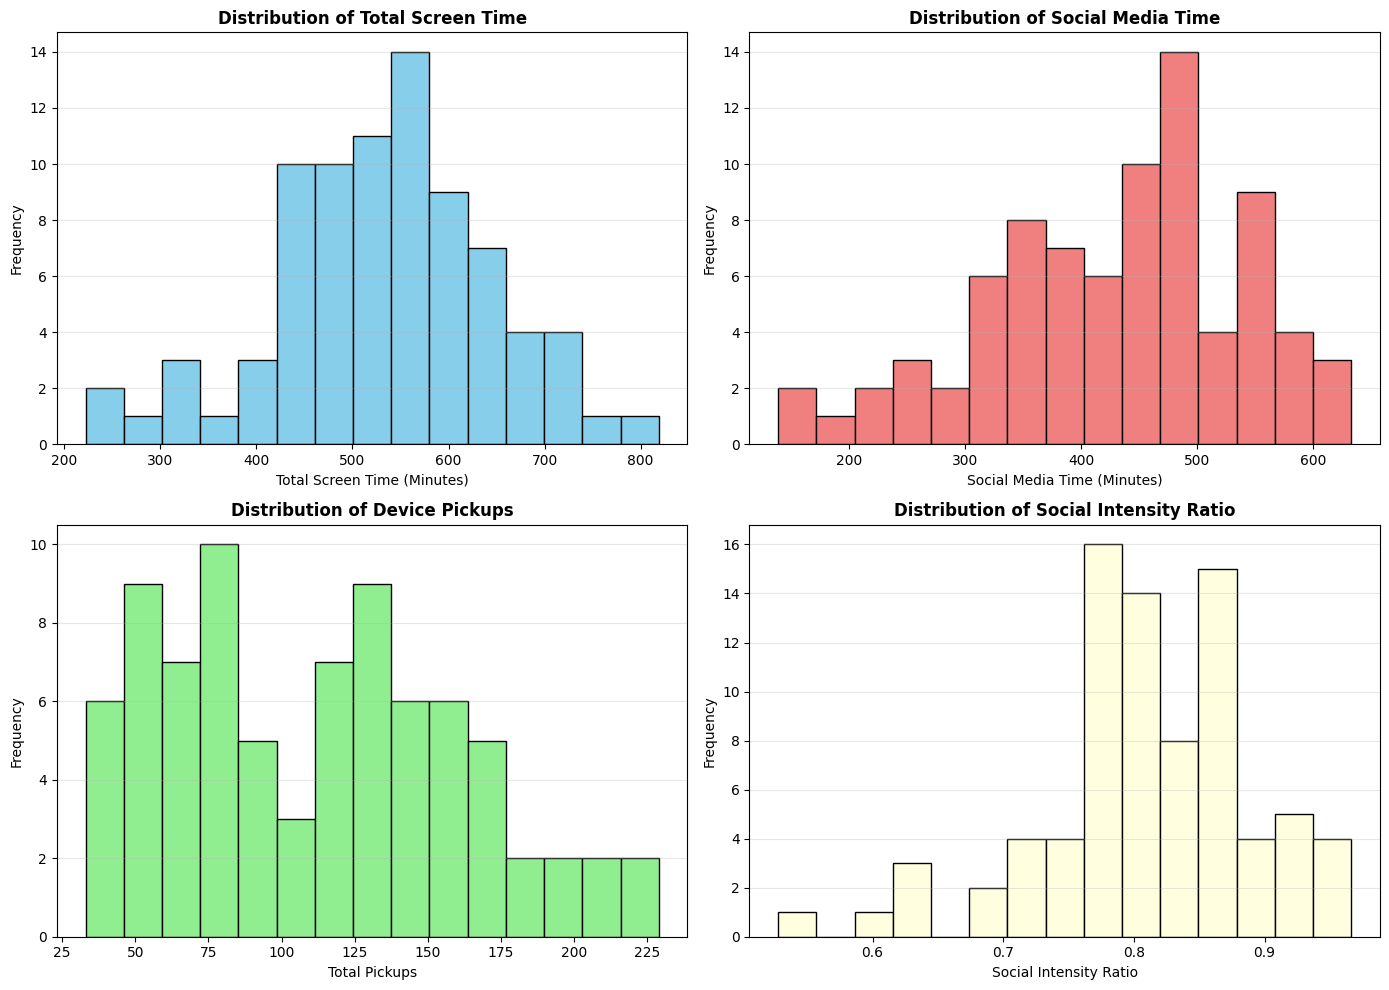

In [57]:
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(df_data['Daily goal-violation'].value_counts())
print(f"\nPercentage distribution:")
print(df_data['Daily goal-violation'].value_counts(normalize=True) * 100)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df_data['Total screen time IN MINUTES (all apps)'], bins=15, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Total Screen Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Screen Time (Minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].hist(df_data['Social apps total time IN MINUTES'], bins=15, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Social Media Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Social Media Time (Minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].hist(df_data['Pickups (total)'], bins=15, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Device Pickups', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Total Pickups')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].hist(df_data['Social Intensity Ratio'], bins=15, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Distribution of Social Intensity Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Social Intensity Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


COMPARISON OF METRICS BY GOAL-VIOLATION STATUS
                                 Metric  No Violation (Mean)  Violation (Mean)  Difference
Total screen time IN MINUTES (all apps)           392.352941        564.765625  172.412684
      Social apps total time IN MINUTES           290.823529        468.062500  177.238971
                 Social Intensity Ratio             0.738297          0.829042    0.090744
                        Pickups (total)           132.941176        105.843750  -27.097426
            First Pickups (social apps)            68.294118         66.750000   -1.544118
                  Notifications (total)           132.882353        205.796875   72.914522
                 Notifications (social)            90.470588        171.562500   81.091912
    Number of distinct social apps used             5.235294          5.140625   -0.094669


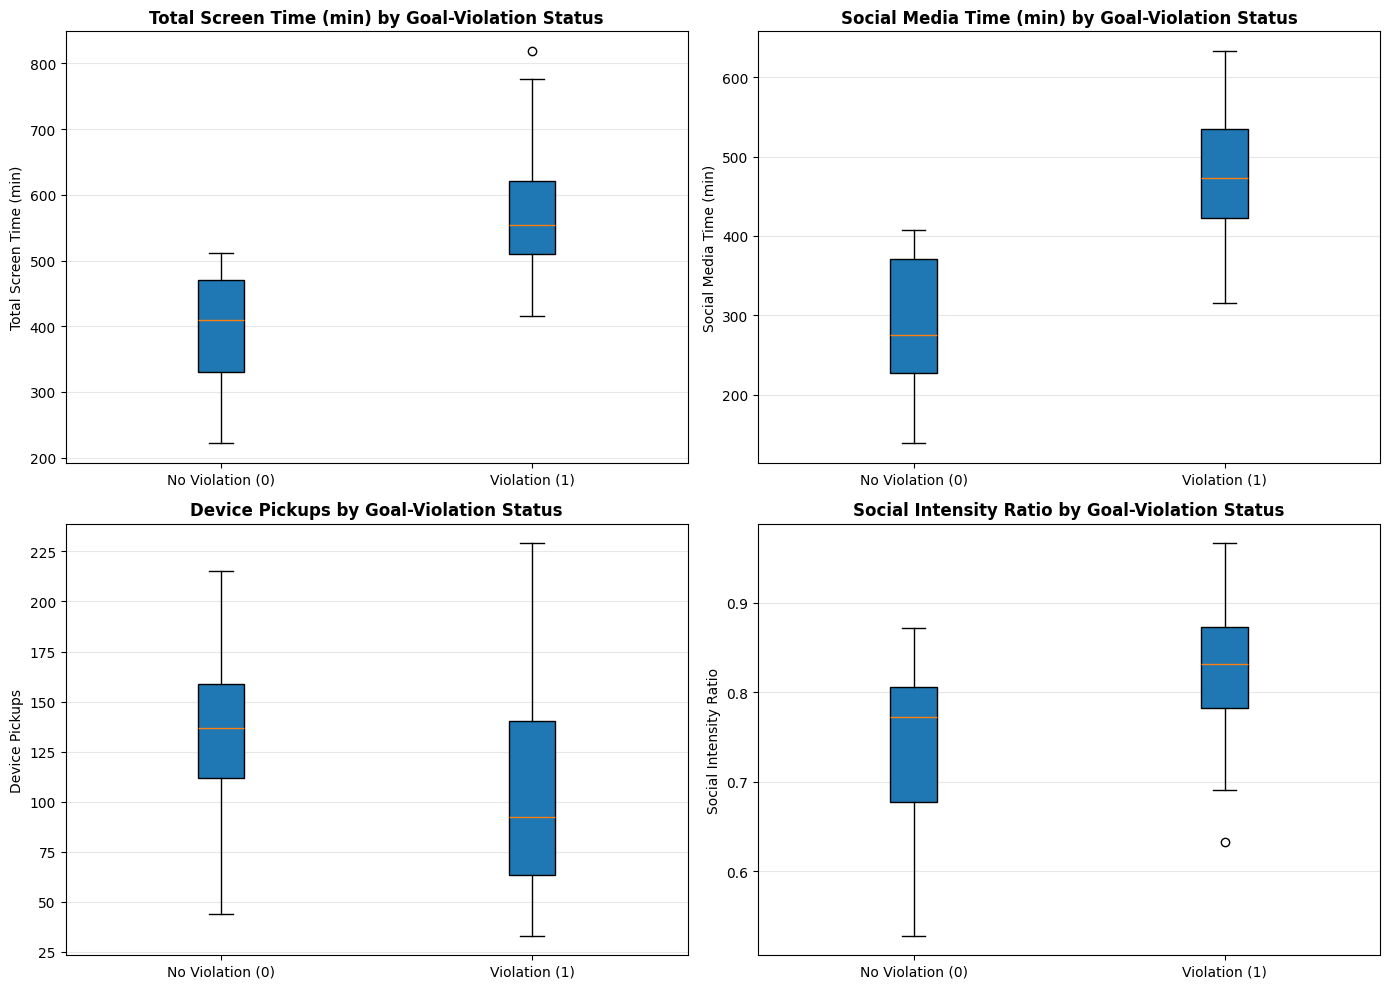

In [58]:
print("\nCOMPARISON OF METRICS BY GOAL-VIOLATION STATUS")
print("=" * 80)

goal_violation_0 = df_data[df_data['Daily goal-violation'] == 0]
goal_violation_1 = df_data[df_data['Daily goal-violation'] == 1]

comparison_metrics = [
    'Total screen time IN MINUTES (all apps)',
    'Social apps total time IN MINUTES',
    'Social Intensity Ratio',
    'Pickups (total)',
    'First Pickups (social apps)',
    'Notifications (total)',
    'Notifications (social)',
    'Number of distinct social apps used'
]

comparison_df = pd.DataFrame({
    'Metric': comparison_metrics,
    'No Violation (Mean)': [goal_violation_0[m].mean() for m in comparison_metrics],
    'Violation (Mean)': [goal_violation_1[m].mean() for m in comparison_metrics],
    'Difference': [goal_violation_1[m].mean() - goal_violation_0[m].mean() for m in comparison_metrics]
})

print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = [
    ('Total screen time IN MINUTES (all apps)', 'Total Screen Time (min)', axes[0, 0]),
    ('Social apps total time IN MINUTES', 'Social Media Time (min)', axes[0, 1]),
    ('Pickups (total)', 'Device Pickups', axes[1, 0]),
    ('Social Intensity Ratio', 'Social Intensity Ratio', axes[1, 1])
]

for metric, title, ax in metrics_to_plot:
    data_to_plot = [goal_violation_0[metric], goal_violation_1[metric]]
    ax.boxplot(data_to_plot, tick_labels=['No Violation (0)', 'Violation (1)'], patch_artist=True)
    ax.set_title(f'{title} by Goal-Violation Status', fontsize=12, fontweight='bold')
    ax.set_ylabel(title)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

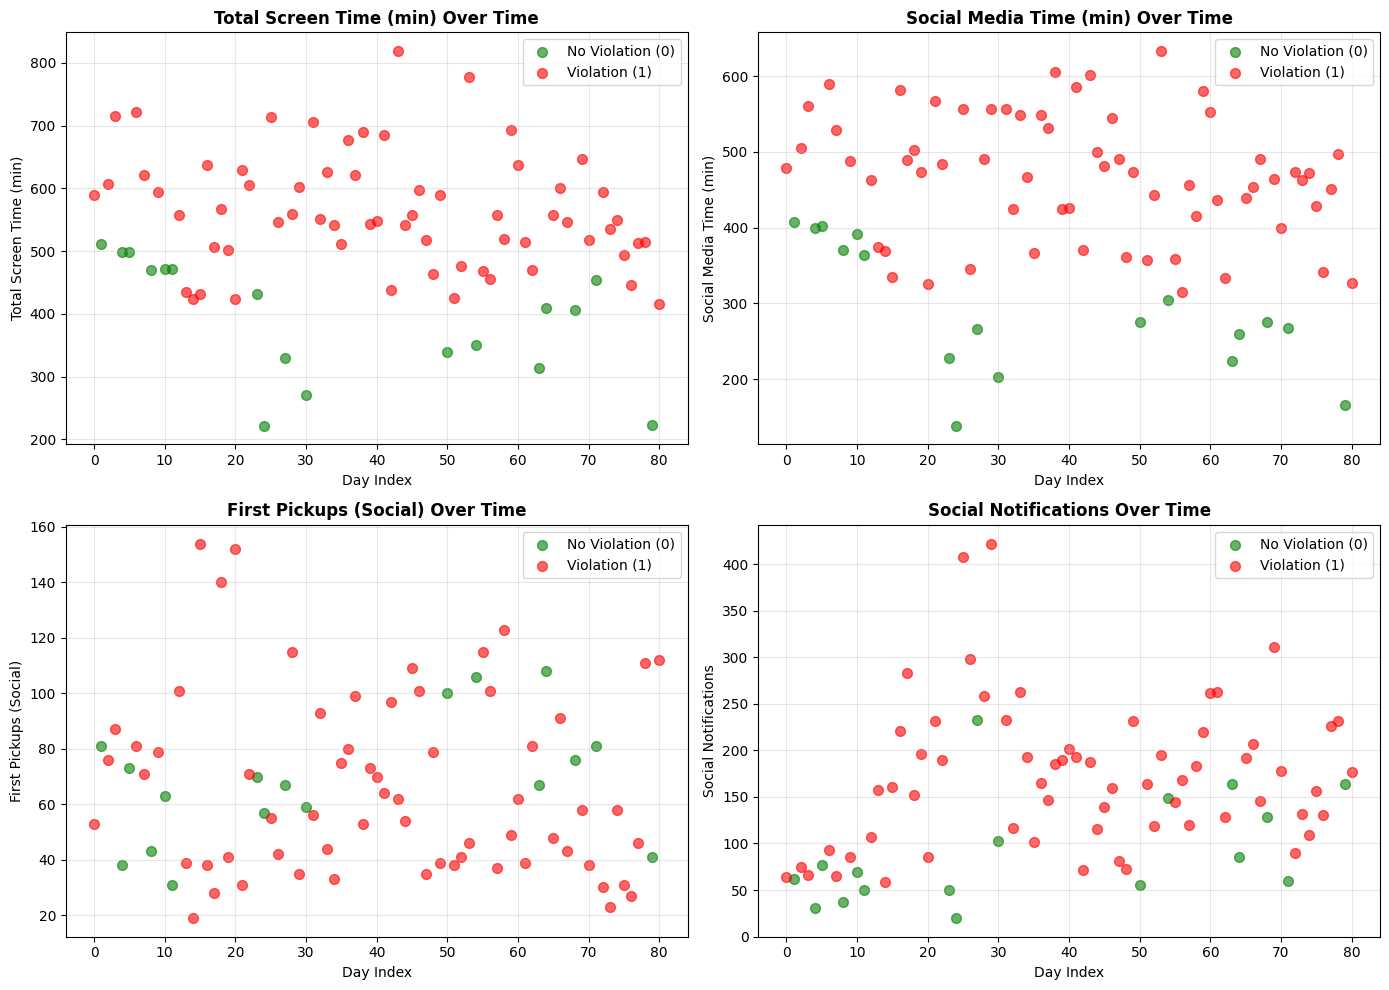

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scatter_metrics = [
    ('Total screen time IN MINUTES (all apps)', 'Total Screen Time (min)', axes[0, 0]),
    ('Social apps total time IN MINUTES', 'Social Media Time (min)', axes[0, 1]),
    ('First Pickups (social apps)', 'First Pickups (Social)', axes[1, 0]),
    ('Notifications (social)', 'Social Notifications', axes[1, 1])
]

mask_0 = df_data['Daily goal-violation'] == 0
mask_1 = df_data['Daily goal-violation'] == 1

for metric, title, ax in scatter_metrics:
    ax.scatter(df_data.index[mask_0], df_data.loc[mask_0, metric], c='green', alpha=0.6, s=50, label='No Violation (0)')
    ax.scatter(df_data.index[mask_1], df_data.loc[mask_1, metric], c='red', alpha=0.6, s=50, label='Violation (1)')
    ax.set_title(f'{title} Over Time', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day Index')
    ax.set_ylabel(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Hypothesis Testing

**Null Hypothesis (H₀):** Daily iOS Screen Time metrics have **no significant association** with daily social media addiction–related behaviour.

**Alternative Hypothesis (H₁):** At least one daily iOS Screen Time metric has a **significant association** with daily social media addiction-related behaviour.

**Significance Level:** α = 0.05

**Test Selection Rationale — Independent Samples t-test (Welch's):**
1. The independent variables are continuous (screen time metrics) and the grouping variable is binary (goal-violation: 0 or 1) — the t-test compares means of each metric between the two groups
2. Welch's t-test is used (does not assume equal variances), which is more robust given the unequal group sizes (17 vs 64)
3. **Cohen's d** is computed as the standardized effect size to quantify the magnitude of group differences
4. Supplemented with logistic regression for predictive modeling

In [60]:
print("\n" + "=" * 90)
print("INDEPENDENT SAMPLES T-TEST (Welch's)")
print("=" * 90)
print("Compares the mean of each metric between Violation (1) and No-Violation (0) days")

group_0 = df_data[df_data['Daily goal-violation'] == 0]
group_1 = df_data[df_data['Daily goal-violation'] == 1]

def cohens_d(g1, g2):
    """Compute Cohen's d for two independent groups."""
    n1, n2 = len(g1), len(g2)
    pooled_std = np.sqrt(((n1 - 1) * g1.std(ddof=1)**2 + (n2 - 1) * g2.std(ddof=1)**2) / (n1 + n2 - 2))
    return (g2.mean() - g1.mean()) / pooled_std if pooled_std > 0 else 0.0

ttest_results = []

for metric in independent_vars:
    t_stat, p_value = ttest_ind(group_0[metric], group_1[metric], equal_var=False)
    d = cohens_d(group_0[metric], group_1[metric])

    abs_d = abs(d)
    if abs_d < 0.2:
        effect = 'Negligible'
    elif abs_d < 0.5:
        effect = 'Small'
    elif abs_d < 0.8:
        effect = 'Medium'
    else:
        effect = 'Large'
    
    ttest_results.append({
        'Metric': metric,
        't-statistic': t_stat,
        'P-value': p_value,
        "Cohen's d": d,
        'Effect Size': effect,
        'Significant (α=0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

correlation_df = pd.DataFrame(ttest_results)
print(correlation_df.to_string(index=False))

significant_count = (correlation_df['Significant (α=0.05)'] == 'Yes').sum()
print(f"\n{'=' * 90}")
print(f"Number of metrics with significant difference: {significant_count}/{len(independent_vars)}")

alpha = 0.05
if significant_count > 0:
    print(f"\n✓ DECISION: REJECT the null hypothesis")
    print(f"At least one screen time metric has a statistically significant difference between")
    print(f"goal-violation and non-violation days.")
else:
    print(f"\n✗ DECISION: FAIL TO REJECT the null hypothesis")
    print(f"No screen time metrics show statistically significant differences between groups.")


INDEPENDENT SAMPLES T-TEST (Welch's)
Compares the mean of each metric between Violation (1) and No-Violation (0) days
                                 Metric  t-statistic      P-value  Cohen's d Effect Size Significant (α=0.05)
Total screen time IN MINUTES (all apps)    -6.630421 7.011820e-07   1.863671       Large                  Yes
      Social apps total time IN MINUTES    -7.658673 6.111026e-08   2.144000       Large                  Yes
                 Social Intensity Ratio    -3.679907 1.429960e-03   1.214962       Large                  Yes
                        Pickups (total)     2.262925 3.109012e-02  -0.551747      Medium                  Yes
            First Pickups (social apps)     0.224074 8.239815e-01  -0.049767  Negligible                   No
                  Notifications (total)    -4.501039 7.657001e-05   1.026356       Large                  Yes
                 Notifications (social)    -4.741587 4.085755e-05   1.102893       Large                  Yes
 

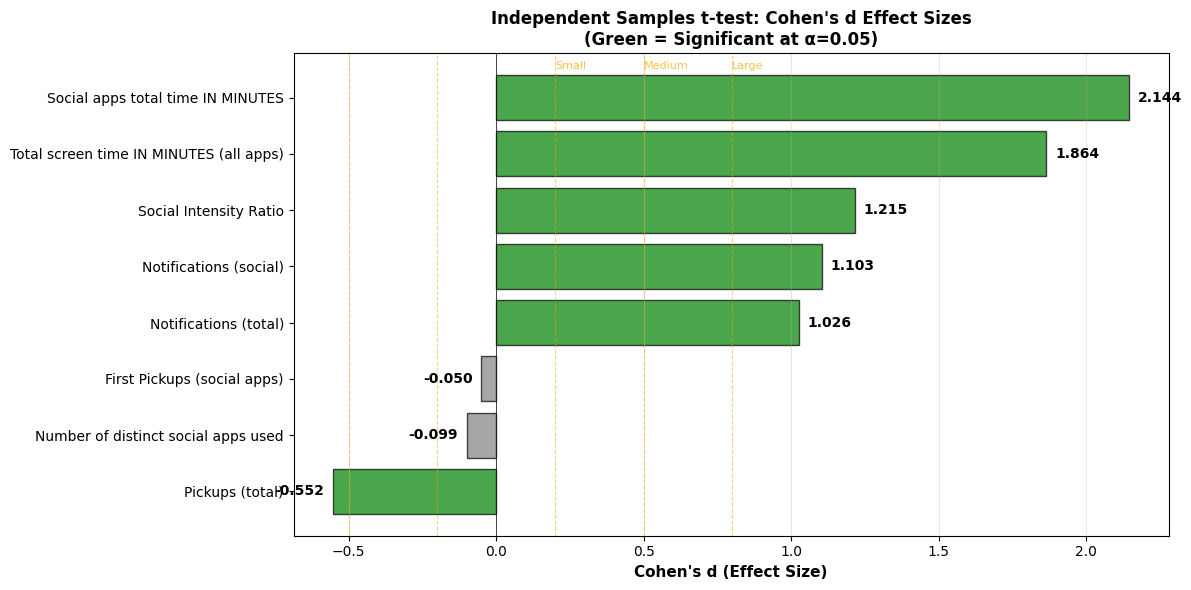

In [61]:
effect_sorted = correlation_df.sort_values("Cohen's d", ascending=True)

colors = ['green' if p < 0.05 else 'gray' for p in effect_sorted['P-value']]
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(effect_sorted)), effect_sorted["Cohen's d"].values, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(effect_sorted)))
ax.set_yticklabels(effect_sorted['Metric'], fontsize=10)
ax.set_xlabel("Cohen's d (Effect Size)", fontsize=11, fontweight='bold')
ax.set_title("Independent Samples t-test: Cohen's d Effect Sizes\n(Green = Significant at α=0.05)", 
             fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add dashed lines for effect size thresholds
ax.axvline(x=0.2, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0.5, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0.8, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=-0.2, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=-0.5, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax.text(0.2, len(effect_sorted) - 0.5, 'Small', fontsize=8, color='orange', alpha=0.7)
ax.text(0.5, len(effect_sorted) - 0.5, 'Medium', fontsize=8, color='orange', alpha=0.7)
ax.text(0.8, len(effect_sorted) - 0.5, 'Large', fontsize=8, color='orange', alpha=0.7)

ax.grid(axis='x', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, effect_sorted["Cohen's d"].values)):
    ax.text(value + 0.03 if value > 0 else value - 0.03, i, f'{value:.3f}', 
            va='center', ha='left' if value > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

### Logistic Regression Model

Since the dependent variable is binary (goal-violation: 0 or 1), logistic regression is the appropriate predictive model. This will help us understand which screen time metrics best predict whether the participant will violate their daily social media goals.

**Validation Strategy:** An 80/20 stratified train-test split is used to evaluate the model on unseen data and avoid overfitting. Stratification ensures both the training and test sets preserve the original class distribution (~79% violation, ~21% no-violation).

**Feature Standardization:** All 8 predictor features are standardized using `StandardScaler` (zero mean, unit variance). The scaler is fit on the training set only to prevent data leakage. Standardization ensures that the resulting logistic regression coefficients are on the same scale, making them directly comparable as a measure of feature importance.

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

print("=" * 90)
print("LOGISTIC REGRESSION MODEL (80/20 Stratified Train-Test Split)")
print("=" * 90)

X = df_data[independent_vars]
y = df_data['Daily goal-violation']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"\nDataset Split:")
print(f"  Training set:  {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"  Test set:      {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)")
print(f"  Train class distribution: {dict(y_train.value_counts())}")
print(f"  Test class distribution:  {dict(y_test.value_counts())}")
print(f"  Feature scaling: StandardScaler (fit on training data only)")

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

print("\nSTANDARDIZED MODEL COEFFICIENTS (effect of 1 SD change in each feature):")
print("-" * 90)
coef_df = pd.DataFrame({
    'Feature': independent_vars,
    'Coefficient': log_reg.coef_[0]
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(coef_df[['Feature', 'Coefficient']].to_string(index=False))
print(f"\nIntercept: {log_reg.intercept_[0]:.4f}")
print("\nNote: Coefficients are on the standardized scale. A coefficient of X means that")
print("a 1 standard deviation increase in the feature changes the log-odds by X.")

# ==================== TRAINING SET METRICS ====================
y_train_pred = log_reg.predict(X_train_scaled)
y_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

print("\n" + "=" * 90)
print("TRAINING SET PERFORMANCE")
print("=" * 90)

train_accuracy = log_reg.score(X_train_scaled, y_train)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

cm_train = confusion_matrix(y_train, y_train_pred)
print(f"\nConfusion Matrix (Train):")
print(cm_train)
print(f"  TN: {cm_train[0,0]}  |  FP: {cm_train[0,1]}")
print(f"  FN: {cm_train[1,0]}  |  TP: {cm_train[1,1]}")

print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['No Violation', 'Violation']))

try:
    train_auc = roc_auc_score(y_train, y_train_proba)
    print(f"ROC-AUC Score (Train): {train_auc:.4f}")
except ValueError:
    train_auc = None
    print("ROC-AUC Score (Train): Could not compute")

# ==================== TEST SET METRICS ====================
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n" + "=" * 90)
print("TEST SET PERFORMANCE (unseen data — used for final conclusions)")
print("=" * 90)

accuracy = log_reg.score(X_test_scaled, y_test)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix (Test):")
print(cm)
print(f"  TN: {cm[0,0]}  |  FP: {cm[0,1]}")
print(f"  FN: {cm[1,0]}  |  TP: {cm[1,1]}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, target_names=['No Violation', 'Violation']))

try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score (Test): {auc_score:.4f}")
except ValueError:
    auc_score = None
    print("ROC-AUC Score (Test): Could not compute")

# ==================== SIDE-BY-SIDE COMPARISON ====================
print("\n" + "=" * 90)
print("TRAIN vs TEST COMPARISON")
print("=" * 90)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Train': [
        f"{train_accuracy*100:.2f}%",
        f"{train_auc:.4f}" if train_auc is not None else "N/A",
        cm_train[0,0], cm_train[0,1], cm_train[1,0], cm_train[1,1]
    ],
    'Test': [
        f"{accuracy*100:.2f}%",
        f"{auc_score:.4f}" if auc_score is not None else "N/A",
        cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    ]
})
print(comparison.to_string(index=False))

gap = (train_accuracy - accuracy) * 100
print(f"\nAccuracy Gap (Train - Test): {gap:.2f} percentage points")
if gap < 0:
    print(f"→ Test accuracy exceeds training accuracy by {abs(gap):.2f} pp — no overfitting detected.")
    print("  This can occur with small test sets where the random split is easily separable.")
elif gap < 5:
    print("→ Small gap: Model generalizes well, minimal overfitting.")
elif gap < 15:
    print("→ Moderate gap: Some overfitting present, but test performance is still informative.")
else:
    print("→ Large gap: Significant overfitting detected. Test results should be interpreted with caution.")

LOGISTIC REGRESSION MODEL (80/20 Stratified Train-Test Split)

Dataset Split:
  Training set:  64 samples (79%)
  Test set:      17 samples (21%)
  Train class distribution: {1: 51, 0: 13}
  Test class distribution:  {1: 13, 0: 4}
  Feature scaling: StandardScaler (fit on training data only)

STANDARDIZED MODEL COEFFICIENTS (effect of 1 SD change in each feature):
------------------------------------------------------------------------------------------
                                Feature  Coefficient
                        Pickups (total)    -1.143575
Total screen time IN MINUTES (all apps)     1.132190
      Social apps total time IN MINUTES     1.041383
            First Pickups (social apps)     0.975147
                 Notifications (social)     0.962475
    Number of distinct social apps used    -0.398232
                 Social Intensity Ratio     0.277306
                  Notifications (total)     0.276930

Intercept: 2.9609

Note: Coefficients are on the standardized sc

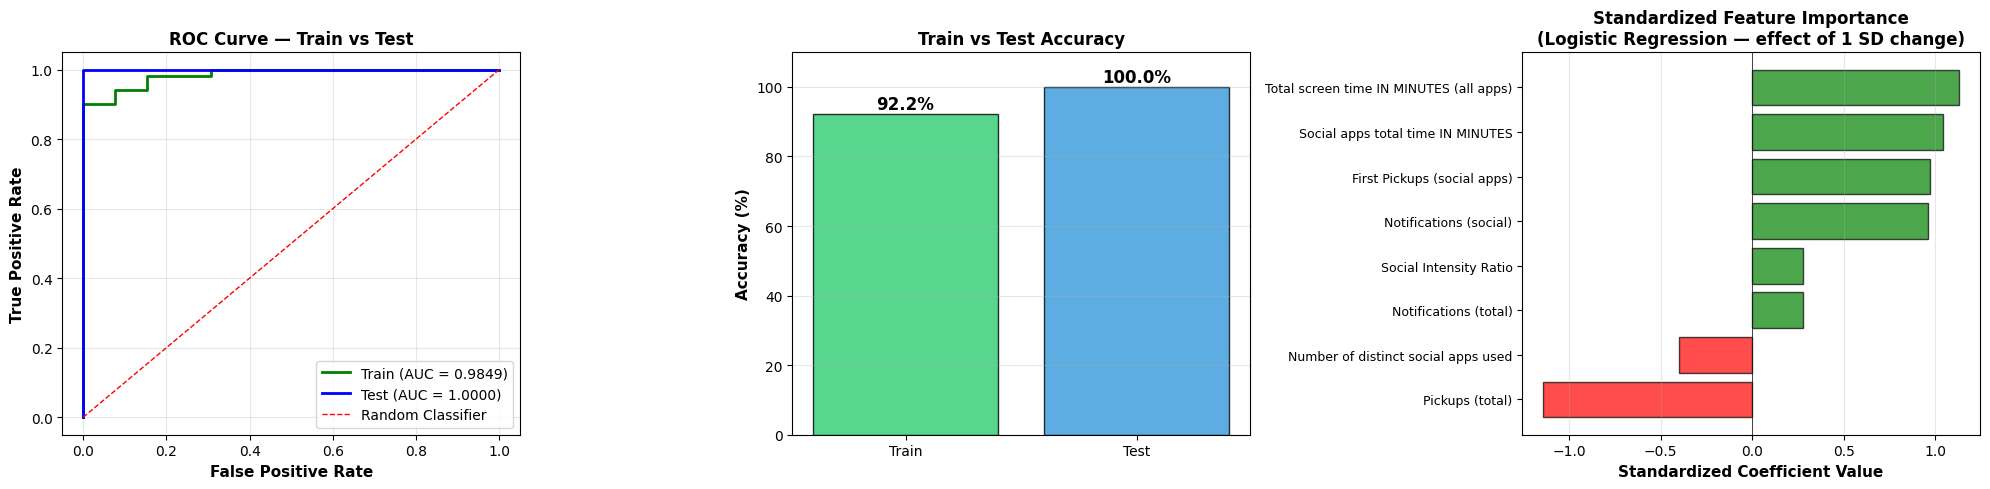

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ROC Curve — Train vs Test overlay
if train_auc is not None:
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    axes[0].plot(fpr_train, tpr_train, 'g-', linewidth=2, label=f'Train (AUC = {train_auc:.4f})')
if auc_score is not None:
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
    axes[0].plot(fpr_test, tpr_test, 'b-', linewidth=2, label=f'Test (AUC = {auc_score:.4f})')
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_title('ROC Curve — Train vs Test', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Train vs Test Accuracy bar chart
bars = axes[1].bar(['Train', 'Test'], [train_accuracy * 100, accuracy * 100],
                    color=['#2ecc71', '#3498db'], edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Train vs Test Accuracy', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 110)
for bar, val in zip(bars, [train_accuracy * 100, accuracy * 100]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
                 f'{val:.1f}%', ha='center', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Feature Importance (Standardized Coefficients)
coef_sorted = coef_df.sort_values('Coefficient')
colors_coef = ['red' if x < 0 else 'green' for x in coef_sorted['Coefficient']]
axes[2].barh(range(len(coef_sorted)), coef_sorted['Coefficient'], color=colors_coef, alpha=0.7, edgecolor='black')
axes[2].set_yticks(range(len(coef_sorted)))
axes[2].set_yticklabels(coef_sorted['Feature'], fontsize=9)
axes[2].set_xlabel('Standardized Coefficient Value', fontsize=11, fontweight='bold')
axes[2].set_title('Standardized Feature Importance\n(Logistic Regression — effect of 1 SD change)', fontsize=12, fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## DISCUSSION

**Research Question:** Is there a statistically significant association between daily iOS Screen Time metrics and daily social media addiction–related behaviour?

**Answer: YES — Strong Evidence of Association**

**Independent Samples t-test (Welch's) Results:**
- **6 out of 8** screen time metrics showed statistically significant mean differences between goal-violation and non-violation days (p < 0.05)
- **Social media time** (d = 2.14, p < 0.001) — Large effect: violation days average ~177 min more social media time
- **Total screen time** (d = 1.86, p < 0.001) — Large effect: violation days average ~172 min more total screen time
- **Social Intensity Ratio** (d = 1.21, p < 0.01) — Large effect: violation days have a higher proportion of social app usage
- **Notifications (social)** (d = 1.10, p < 0.001) — Large effect: violation days receive more social notifications
- **Notifications (total)** (d = 1.03, p < 0.001) — Large effect: violation days receive more total notifications
- **Total pickups** (d = -0.55, p = 0.031) — Medium effect: violation days actually have *fewer* device pickups

**Logistic Regression Model:**
- Model was validated using an **80/20 stratified train-test split** to ensure honest evaluation on unseen data
- Features were standardized (StandardScaler, fit on training data only) to make coefficients directly comparable
- Training set: 64 samples / Test set: 17 samples
- Both training and test performance are reported; conclusions are drawn from the **test set**

**Why do these patterns exist?**
- Higher social media time and total screen time likely reflect prolonged engagement sessions where self-regulation breaks down
- More notifications may trigger compulsive checking, leading to unplanned usage
- The negative effect on pickups suggests that brief, frequent checks (high pickups, low duration) may indicate more disciplined usage than fewer but longer sessions

## CONCLUSION

### Key Findings

1. **Social media time shows the largest group difference** (Cohen's d = 2.14, p < 0.001) — violation days have substantially higher social media usage
2. **6 out of 8 screen time metrics** show statistically significant differences between violation and non-violation days at α = 0.05
3. The logistic regression model, validated on a held-out test set with standardized features, demonstrates that screen time metrics can predict goal-violation behaviour
4. **The participant violates daily goals ~79% of the time** (64 out of 81 days), suggesting goals may need revision or stronger behavioural strategies

In [64]:
print("\n" + "=" * 100)
print("EXECUTIVE SUMMARY - PROJECT FINDINGS")
print("=" * 100)

n_total = len(df_data)
n_violations = (df_data['Daily goal-violation'] == 1).sum()
n_no_violations = (df_data['Daily goal-violation'] == 0).sum()
violation_rate = n_violations / n_total * 100

# Find the metric with the largest absolute Cohen's d
top_metric = correlation_df.loc[correlation_df["Cohen's d"].abs().idxmax()]

summary_data = {
    'Aspect': [
        'Study Design',
        'Sample Size',
        'Data Duration',
        'Key Variables',
        'Goal-Violation Rate',
        't-test Result',
        'Statistical Decision',
        'Validation Strategy',
        'Test Accuracy',
        'Largest Effect Size',
        'Primary Finding'
    ],
    'Details': [
        'Single participant, daily repeated measures (each row = one 24-hour day)',
        f'N=1 participant, {n_total} daily observations',
        'November 19, 2025 to February 7, 2026 (~81 days)',
        '8 Screen Time metrics + 1 Behavioral outcome',
        f'{n_violations} violations out of {n_total} days ({violation_rate:.2f}%)',
        f'{(correlation_df["Significant (α=0.05)"] == "Yes").sum()} of 8 metrics significant at p<0.05',
        'REJECT null hypothesis - Significant differences found',
        f'80/20 Stratified Train-Test Split (Train: {len(X_train)}, Test: {len(X_test)})',
        f'{accuracy*100:.2f}%' + (f' (ROC-AUC: {auc_score:.4f})' if auc_score is not None else ''),
        f'{top_metric["Metric"]} (d={top_metric["Cohen\'s d"]:.3f}, p={top_metric["P-value"]:.2e})',
        'iOS Screen Time metrics significantly differ between goal-violation and non-violation days'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 100)
print("STATISTICALLY SIGNIFICANT METRICS (Welch's t-test)")
print("=" * 100)
sig_metrics = correlation_df[correlation_df['Significant (α=0.05)'] == 'Yes'].copy()
sig_metrics = sig_metrics[['Metric', "Cohen's d", 'P-value', 'Effect Size']].sort_values("Cohen's d", ascending=False)
print(sig_metrics.to_string(index=False))

print("\n" + "=" * 100)
print("DATASET QUALITY ASSESSMENT")
print("=" * 100)
print(f"Total Records: {n_total}")
print(f"Complete Cases: {n_total} (100%)")
print(f"Missing Values: {df_data.isnull().sum().sum()}")


EXECUTIVE SUMMARY - PROJECT FINDINGS
              Aspect                                                                                    Details
        Study Design                   Single participant, daily repeated measures (each row = one 24-hour day)
         Sample Size                                                     N=1 participant, 81 daily observations
       Data Duration                                           November 19, 2025 to February 7, 2026 (~81 days)
       Key Variables                                               8 Screen Time metrics + 1 Behavioral outcome
 Goal-Violation Rate                                                      64 violations out of 81 days (79.01%)
       t-test Result                                                       6 of 8 metrics significant at p<0.05
Statistical Decision                                     REJECT null hypothesis - Significant differences found
 Validation Strategy                                    80/20 Stra